# Plot results from 200 simulations - with grid searching C

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

#### Settings and specs

In [2]:
dir_data_in = '../../output/data/stats'
fig_dir = '../../output/'

snrs = np.arange(-45, 10, 5)

# the grid search results only exist for this combination:
contrast = 'vis_aud'

In [3]:
conditions = ['sensor', 'source', 'csp']

file_sets = dict(sensor=['sensor_scores_%s_%.3f.npy', 'cv_sensor_scores_%s_%.3f.npy'], 
                  source=['csp_scores_%s_%.3f.npy', 'cv_csp_scores_%s_%.3f.npy'],
                  csp=['source_scores_%s_%.3f.npy', 'cv_source_scores_%s_%.3f.npy'])
titles = dict(sensor='Sensor space', source='Source space', csp='CSP sensor space')
colors = dict(sensor='#01abe9', source='#1b346c', csp='#f54b1a', optimal='#a9babc')
legend = ['Regularization C=1.0', 'Optimal regularization']

### Compare optimal and fixed C

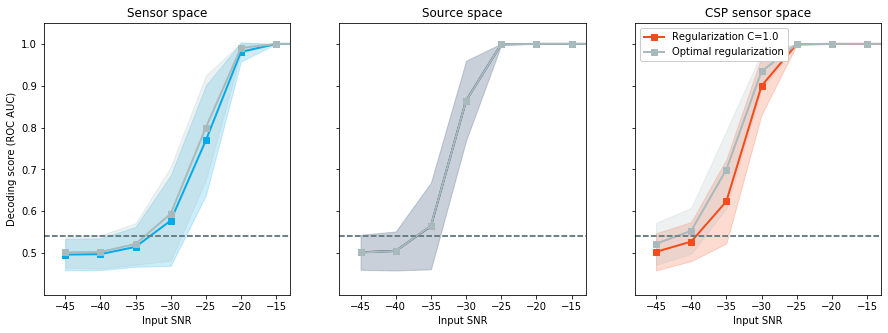

In [4]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

for cond, ax in zip(conditions, axs):
 
    # loop over optimal vs C=1.0
    for f_name, leg in zip(file_sets[cond], legend):
    
        mean_score = []
        std_low = []
        std_up = []

        for snr in snrs:          

            # load the data for that condition, regularization, and input SNR
            file_name = op.join(dir_data_in, f_name)
            score = np.load(file_name % (contrast, snr)) 

            mean_score.append(np.mean(score))
            std_low.append(np.mean(score) - np.std(score))
            std_up.append(np.mean(score) + np.std(score))        
 
        # get color right:
        if 'cv_' in f_name:
            col = colors['optimal']
        else:
            col = colors[cond]
        
        # plot:
        ax.plot(snrs, mean_score, color=col, marker='s', linewidth=2, label=leg)
        ax.fill_between(snrs, std_low, std_up, color=col, alpha=0.2)
    
        ax.axhline(y=.54, color='#657c81', linestyle='--')
        ax.set_xlabel('Input SNR')
        
        if cond == 'sensor':
            ax.set_ylabel('Decoding score (ROC AUC)')  # only label first y-axis
        
        ax.set_title(titles[cond])

# x-axes (shared):
plt.xlim(-48, -13)

# y-axes (shared):
plt.ylim(0.4, 1.05)
yticks = list(np.arange(0.5, 1.05, 0.1))
plt.yticks(yticks, [str(round(x, 1)) for x in yticks])


plt.legend(loc='upper left', framealpha=1.0)

fig_fname = op.join(fig_dir, 'comparing_c_%s.pdf' % contrast)
plt.savefig(fig_fname)

plt.show()       
        

### Plot optimal C parameter

In [5]:
file_names = dict(sensor='cv_sensor_c_%s_%.3f.npy', 
                  csp='cv_csp_c_%s_%.3f.npy',
                  source='cv_source_c_%s_%.3f.npy')
snr_sets = [np.arange(-45, -15, 5),         
            np.arange(-20, 10, 5)]  # SNR is split to be able to zoom y axis

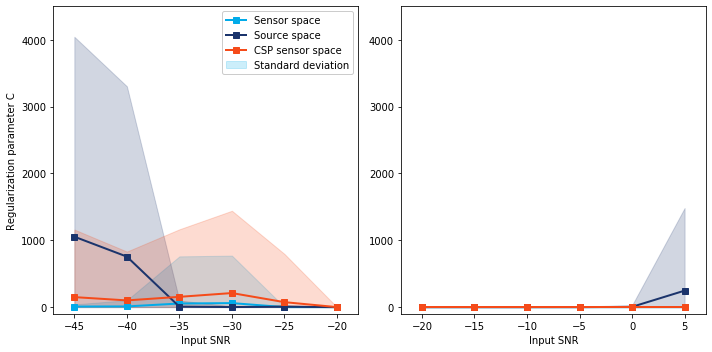

In [6]:
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 5))

for ii, (snr_set, ax) in enumerate(zip(snr_sets, axs)):

    for cond in conditions:

        mean_c = []
        std_low = []
        std_up = []   
        
        for snr in snr_set:

            file_name = op.join(dir_data_in, file_names[cond])
            best_c = np.load(file_name % (contrast, snr))

            mean_c.append(np.mean(best_c))
            std_low.append(np.mean(best_c) - np.std(best_c))
            std_up.append(np.mean(best_c) + np.std(best_c))

        # fix lower bound of standard deviation to not have negative numbers
        std_low = [0 if x < 0 else x for x in std_low]
        # Plot, split by SNR to have y-axis zoom in
        ax.plot(snr_set, mean_c, color=colors[cond], marker='s', linewidth=2, label=titles[cond])
        ax.fill_between(snr_set, std_low, std_up, alpha=0.2, color=colors[cond],
                        label=("Standard deviation" if cond == 'sensor' else None))
    
    ax.set_xlabel('Input SNR')
    ax.set_ylim(-100, 4500)
    if ii == 0:
        ax.legend(loc='upper right', framealpha=1.0)
        ax.set_ylabel('Regularization parameter C')
        ax.set_xlim((-47, -18))  # making sure x-axis has same length (for publishable fig.)
    else:
        ax.set_xlim((-22, 7))  # making sure x-axis has same length 
        
fig_fname = op.join(fig_dir, 'cv_c_%s.pdf' % contrast)
plt.tight_layout()
plt.savefig(fig_fname)
plt.show()
